Enter the ticker symbol (e.g., AAPL):  AAPL
Enter the start date (mm/dd/yyyy):  12/31/2023
Enter the investment amount (e.g., 10000):  10000
Enter the number of time intervals (days) for Monte Carlo simulation:  250
Enter the number of simulations for Monte Carlo simulation:  10000



--------------------------------------------------------------------------------
                               Apple Inc. (AAPL)                                
--------------------------------------------------------------------------------


------------------- Key Financial Metrics -------------------

Metric                   Value                    Description
---------------------------------------------------------------------------
Market Cap               3,444,336,754,688.00     Total market value of a company’s outstanding shares
Enterprise Value         3,496,467,759,104.00     Company value including debt and excluding cash
Trailing P/E             34.48                    Price-to-Earnings ratio based on past 12 months earnings
Forward P/E              30.29                    Price-to-Earnings ratio based on future earnings estimates
PEG Ratio                3.06                     P/E ratio divided by expected earnings growth rate
Price to Sales           8.93      

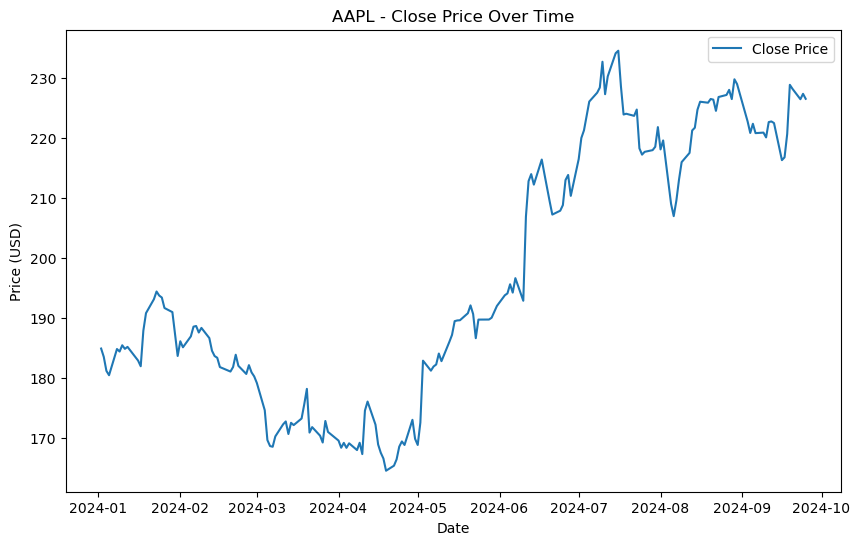


Explanation: The chart above shows the Close price of AAPL over time. It provides a historical view of the stock's price movement adjusted for corporate actions like dividends and splits if the 'Adj Close' is used.


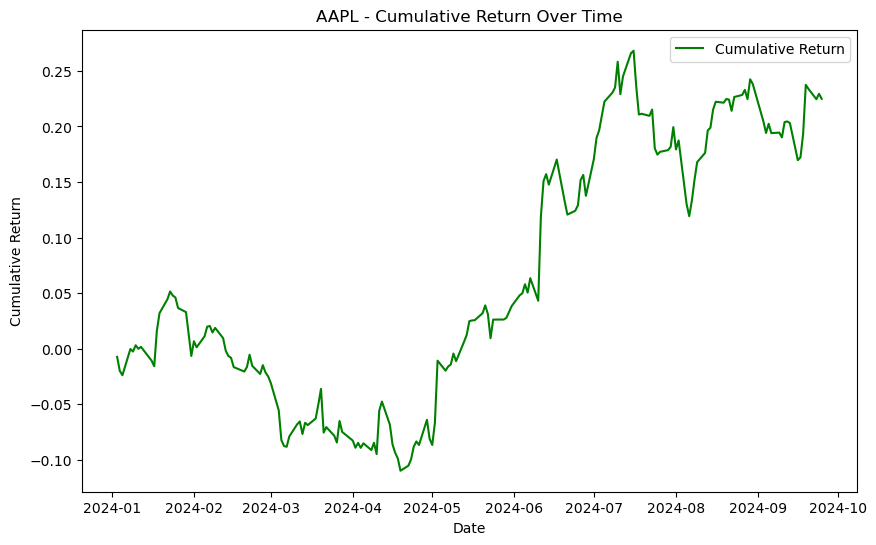


Explanation: The cumulative return shows how much a stock has gained or lost over the entire period starting from the first trading day in the dataset. A positive value indicates growth in the stock, while a negative value indicates a loss over the selected period.


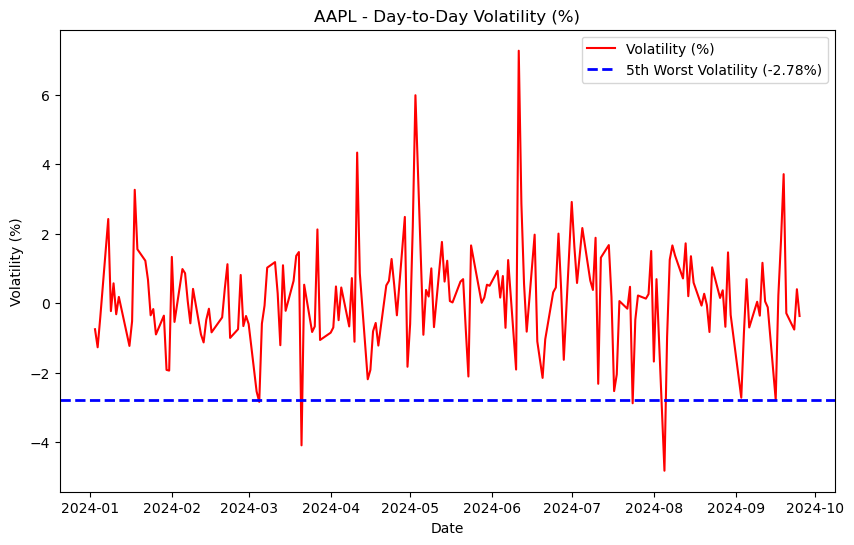


Explanation: The chart above shows the day-to-day percentage volatility of AAPL. The blue dashed line indicates the 5th worst volatility during the period, which helps identify significant negative fluctuations in stock price.


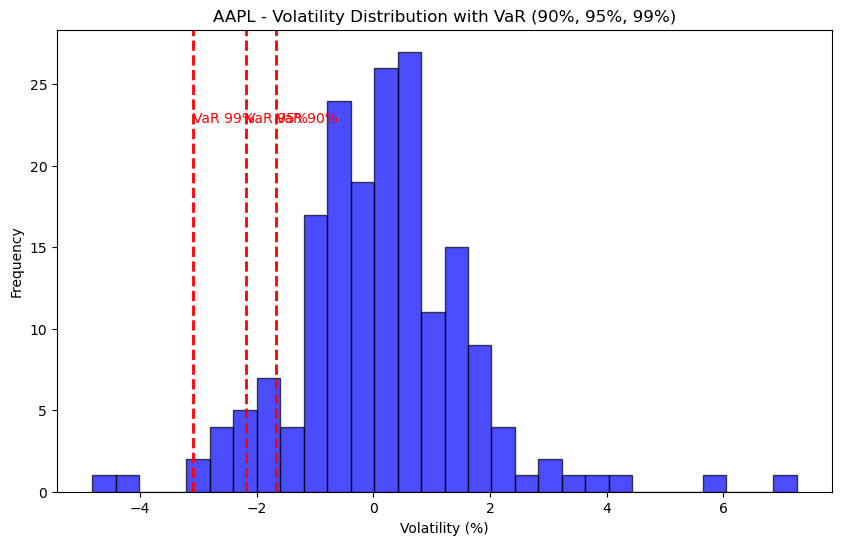


Explanation: This histogram represents the distribution of day-to-day volatility for AAPL. The red lines indicate Value at Risk (VaR) levels at different confidence intervals. For example, at 99% confidence, there is a 1% chance the stock will experience a day with volatility worse than the corresponding VaR.


Enter the interval number to highlight (between 0 and 249):  1



Running Monte Carlo simulation...



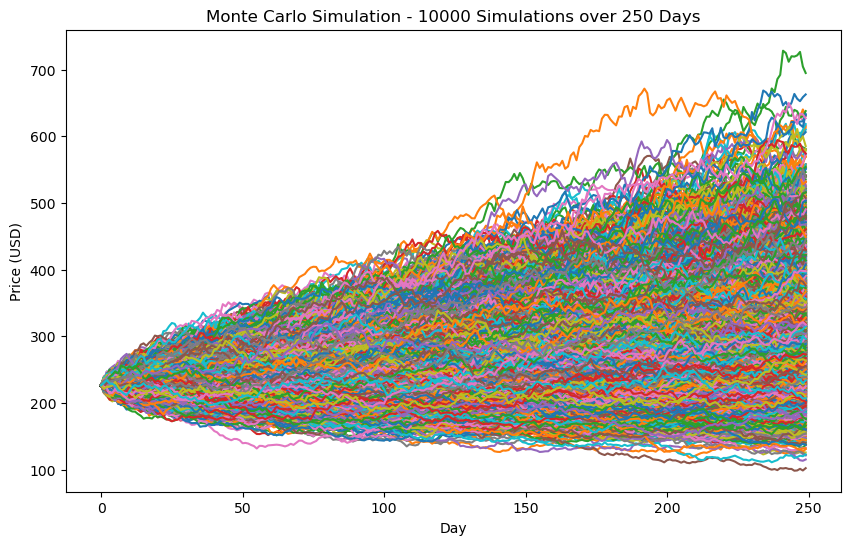

Worst Simulation $/share: 102.08
Avg Simulation $/share: 298.84
Best Simulation $/share: 695.11

Explanation: The Monte Carlo simulation estimates potential future stock prices based on historical log returns. The worst, average, and best simulated outcomes are displayed to give an idea of the possible range of stock prices for AAPL after 250 days.

Confidence Intervals
1 Sigma (1 S.D): 68% confident that price after 250 days will fall between: $227.89 and $369.80
2 Sigma (2 S.D): 95% confident that price after 250 days will fall between: $156.93 and $440.75

Explanation: The confidence intervals (1 and 2 standard deviations) indicate the range within which we expect the stock price to fall with 68% and 95% confidence, respectively. These intervals help gauge the risk of price changes.


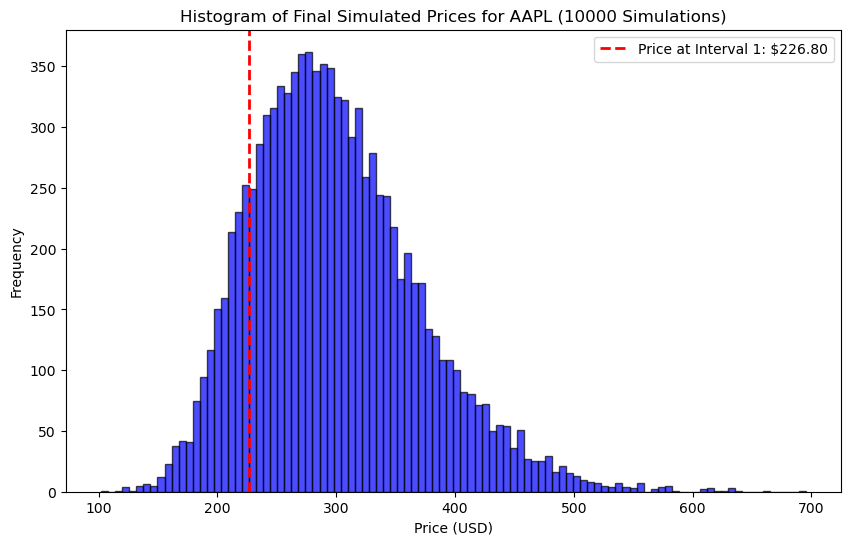


Explanation: The histogram above shows the distribution of final simulated stock prices after the Monte Carlo simulation. The red dashed line highlights the average stock price at the user-chosen interval 1, which is approximately $226.80. This line represents the average of the simulated prices at the selected time point, but individual simulations may vary significantly above or below this value. The histogram provides a sense of the range of possible stock prices.


In [6]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import norm

# Function to retrieve data from yfinance based on user input
def get_stock_data(ticker, start_date):
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date)
    return data

# Function to calculate EV and Equity Value from yfinance
def calculate_metrics_accurate(ticker):
    stock = yf.Ticker(ticker)
    
    # Fetch data from yfinance
    market_cap = stock.info['marketCap']  # Market Cap in USD
    
    # Handling possible missing or alternative field names for 'Cash' and 'Total Debt'
    balance_sheet = stock.balance_sheet
    
    # Look for common variations of Cash
    cash_labels = ['Cash', 'Cash and Cash Equivalents', 'Cash & Equivalents']
    for label in cash_labels:
        if label in balance_sheet.index:
            cash = balance_sheet.loc[label][-1]
            break
    else:
        cash = 0  # Default if no cash label is found
    
    # Look for common variations of Total Debt
    debt_labels = ['Total Debt', 'Long Term Debt', 'Short Term Debt', 'Total Liabilities']
    for label in debt_labels:
        if label in balance_sheet.index:
            debt = balance_sheet.loc[label][-1]
            break
    else:
        debt = 0  # Default if no debt label is found
    
    # Calculate Enterprise Value
    ev = market_cap + debt - cash  # Use the most recent values
    
    # Calculate Equity Value
    equity_value = ev - debt
    
    metrics = {
        'Market Cap': market_cap,
        'Total Debt': debt,
        'Cash': cash,
        'Enterprise Value': ev,
        'Equity Value': equity_value
    }
    
    return metrics

def get_price_column(data):
    # Check if 'Adj Close' is in the data, else fallback to 'Close'
    if 'Adj Close' in data.columns:
        return 'Adj Close'
    else:
        return 'Close'  # Fallback to 'Close' if 'Adj Close' is not available
    
# Function to calculate EPS and day-to-day volatility (percentage change with sign)
def calculate_eps_and_volatility(data, shares_outstanding=1_000_000):
    # Check if 'Adj Close' is in the data, else fallback to 'Close'
    if 'Adj Close' in data.columns:
        price_column = 'Adj Close'
    else:
        price_column = 'Close'  # Fallback to 'Close' if 'Adj Close' is not available
    
    data['EPS'] = data[price_column] / shares_outstanding  # Placeholder for EPS based on adjusted close
    data['Volatility'] = data[price_column].pct_change() * 100  # Day-to-day percentage change in price (volatility)
    data['Volatility'] = data['Volatility'].round(2)  # Round to 2 decimal places
    return data

# Function to calculate backtesting, min/max returns, and standard deviation
def calculate_backtesting_and_stats(data, investment_amount):
    price_column = get_price_column(data)

    # Calculate daily returns
    data['Daily Return'] = data[price_column].pct_change() * 100  # Daily return in percentage

    # Cumulative returns for backtesting
    data['Cumulative Return'] = (1 + data[price_column].pct_change()).cumprod() - 1  # Cumulative return

    # Calculate statistics
    max_gain = data['Daily Return'].max()
    max_loss = data['Daily Return'].min()
    std_dev = data['Daily Return'].std()

    # Calculate cumulative return over the whole period
    cumulative_return = data['Cumulative Return'].iloc[-1] * 100

    # Calculate daily value change based on investment amount
    data['Daily Value Change'] = (data['Daily Return'] / 100) * investment_amount

    # Maximum gain and loss in monetary terms
    max_value_gain = data['Daily Value Change'].max()
    max_value_loss = data['Daily Value Change'].min()

    # Calculate fifth worst loss
    sorted_losses = data['Daily Value Change'].sort_values()
    fifth_worst_loss = sorted_losses.iloc[4]  # Fifth worst loss

    # Store statistics in a dictionary
    stats = {
        'Maximum Gain (%)': max_gain,
        'Maximum Loss (%)': max_loss,
        'Standard Deviation (%)': std_dev,
        'Cumulative Return (%)': cumulative_return,
        'Max Gain (Monetary)': max_value_gain,
        'Max Loss (Monetary)': max_value_loss,
        'Fifth Worst Loss (Monetary)': fifth_worst_loss
    }

    return data, stats

# Function to plot EPS, adjusted closing price, and volatility as separate figures, and add VaR to the volatility histogram
def plot_data_with_explanation(data, ticker):
    price_column = get_price_column(data)

    # Plot Adjusted Close Price or Close Price
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data[price_column], label=f'{price_column} Price')
    plt.title(f'{ticker} - {price_column} Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(False)
    plt.show()
    
    # Explanation
    print(f"\nExplanation: The chart above shows the {price_column} price of {ticker} over time. "
          "It provides a historical view of the stock's price movement adjusted for corporate actions like dividends and splits "
          "if the 'Adj Close' is used.")

    # Plot Cumulative Return
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Cumulative Return'], label='Cumulative Return', color='green')
    plt.title(f'{ticker} - Cumulative Return Over Time')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(False)
    plt.show()
    
    # Explanation
    print("\nExplanation: The cumulative return shows how much a stock has gained or lost over the entire period "
          "starting from the first trading day in the dataset. A positive value indicates growth in the stock, "
          "while a negative value indicates a loss over the selected period.")

    # Plot volatility (as time series)
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Volatility'], label='Volatility (%)', color='red')
    plt.title(f'{ticker} - Day-to-Day Volatility (%)')
    plt.xlabel('Date')
    plt.ylabel('Volatility (%)')

    # Calculate and plot the fifth worst volatility
    sorted_volatility = data['Volatility'].sort_values()
    fifth_worst_volatility = sorted_volatility.iloc[4]  # Fifth worst volatility

    plt.axhline(fifth_worst_volatility, color='blue', linestyle='dashed', linewidth=2, label=f'5th Worst Volatility ({fifth_worst_volatility:.2f}%)')
    
    plt.legend()
    plt.grid(False)
    plt.show()
    
    # Explanation
    print(f"\nExplanation: The chart above shows the day-to-day percentage volatility of {ticker}. The blue dashed line "
          f"indicates the 5th worst volatility during the period, which helps identify significant negative fluctuations in stock price.")

    # Plot histogram of volatility and show VaR at 90%, 95%, and 99% confidence levels
    returns = data['Volatility'].dropna()
    plt.figure(figsize=(10, 6))
    plt.hist(returns, bins=30, color='blue', edgecolor='black', alpha=0.7)

    # Calculate and show VaR at different confidence levels
    percentiles = [10, 5, 1]
    for p in percentiles:
        var_value = np.percentile(returns, p)
        confidence = (100 - p) / 100
        plt.axvline(var_value, color='red', linestyle='dashed', linewidth=2)
        plt.text(var_value, plt.ylim()[1]*0.8, f'VaR {confidence:.0%}', color='red')

    plt.title(f'{ticker} - Volatility Distribution with VaR (90%, 95%, 99%)')
    plt.xlabel('Volatility (%)')
    plt.ylabel('Frequency')
    plt.grid(False)
    plt.show()
    
    # Explanation
    print(f"\nExplanation: This histogram represents the distribution of day-to-day volatility for {ticker}. "
          "The red lines indicate Value at Risk (VaR) levels at different confidence intervals. "
          "For example, at 99% confidence, there is a 1% chance the stock will experience a day with volatility worse than the corresponding VaR.")  

# Monte Carlo simulation for future stock prices with explanations and histogram, highlighting user-chosen interval
def monte_carlo_simulation(data, t_intervals, simulations, highlight_interval):
    price_column = get_price_column(data)

    log_returns = np.log(1 + data[price_column].pct_change())
    
    mean = log_returns.mean()
    variance = log_returns.var()
    std = log_returns.std()

    # Simulate future daily returns
    daily_logreturns_simulated = std * norm.ppf(np.random.rand(t_intervals, simulations))
    drift = mean - (0.5 * variance)
    daily_logreturns_simulated_with_drift = daily_logreturns_simulated + drift
    daily_simplereturns_simulated_with_drift = np.exp(daily_logreturns_simulated_with_drift)

    # Latest known stock price
    last_price = data[price_column].iloc[-1]

    # Prepare an array for the price simulations
    price_list = np.zeros_like(daily_simplereturns_simulated_with_drift)
    price_list[0] = last_price

    # Apply a for loop for simulated prices
    for t in range(1, t_intervals):
        price_list[t] = price_list[t - 1] * daily_simplereturns_simulated_with_drift[t]

    # Plot simulated future prices
    plt.figure(figsize=(10, 6))
    plt.plot(price_list)
    plt.title(f"Monte Carlo Simulation - {simulations} Simulations over {t_intervals} Days")
    plt.xlabel("Day")
    plt.ylabel("Price (USD)")
    plt.grid(False)
    plt.show()

    # Calculate worst, avg, and best scenarios
    worst_sim = round(price_list[-1].min(), 2)
    avg_sim = round(price_list[-1].mean(), 2)
    best_sim = round(price_list[-1].max(), 2)

    # Display the results
    print(f"Worst Simulation $/share: {worst_sim}")
    print(f"Avg Simulation $/share: {avg_sim}")
    print(f"Best Simulation $/share: {best_sim}")

    # Explanation
    print("\nExplanation: The Monte Carlo simulation estimates potential future stock prices based on historical log returns. "
          f"The worst, average, and best simulated outcomes are displayed to give an idea of the possible range of stock prices for {ticker} after {t_intervals} days.")
    
    # Set up confidence intervals
    mean_day250_prices = price_list[-1].mean()
    sd_day250_prices = price_list[-1].std()
    upper_interval_1sd = mean_day250_prices + 1 * sd_day250_prices
    lower_interval_1sd = mean_day250_prices - 1 * sd_day250_prices
    upper_interval_2sd = mean_day250_prices + 2 * sd_day250_prices
    lower_interval_2sd = mean_day250_prices - 2 * sd_day250_prices

    print("\nConfidence Intervals")
    print(f"1 Sigma (1 S.D): 68% confident that price after {t_intervals} days will fall between: ${lower_interval_1sd:.2f} and ${upper_interval_1sd:.2f}")
    print(f"2 Sigma (2 S.D): 95% confident that price after {t_intervals} days will fall between: ${lower_interval_2sd:.2f} and ${upper_interval_2sd:.2f}")

    # Explanation of confidence intervals
    print("\nExplanation: The confidence intervals (1 and 2 standard deviations) indicate the range within which we expect "
          "the stock price to fall with 68% and 95% confidence, respectively. These intervals help gauge the risk of price changes.")

    # Plot histogram of final prices from all simulations
    plt.figure(figsize=(10, 6))
    plt.hist(price_list[-1], bins=100, color='blue', edgecolor='black', alpha=0.7)
    
    # Highlight the user-chosen interval
    chosen_price = price_list[highlight_interval].mean()
    plt.axvline(chosen_price, color='red', linestyle='dashed', linewidth=2, label=f'Price at Interval {highlight_interval}: ${chosen_price:.2f}')
    
    plt.title(f'Histogram of Final Simulated Prices for {ticker} ({simulations} Simulations)')
    plt.xlabel('Price (USD)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(False)
    plt.show()

# Explanation of histogram and the red dashed line
    print(f"\nExplanation: The histogram above shows the distribution of final simulated stock prices after the Monte Carlo simulation. "
          f"The red dashed line highlights the average stock price at the user-chosen interval {highlight_interval}, "
          f"which is approximately ${chosen_price:.2f}. This line represents the average of the simulated prices at the selected time point, "
          "but individual simulations may vary significantly above or below this value. The histogram provides a sense of the range of possible stock prices.")

# Function to fetch key financial metrics using yfinance
def fetch_financial_metrics(ticker):
    stock = yf.Ticker(ticker)
    info = stock.info
    
    # Retrieve key financial metrics from the info dictionary
    market_cap = info.get('marketCap', 'N/A')  # Market Cap
    enterprise_value = info.get('enterpriseValue', 'N/A')  # Enterprise Value
    trailing_pe = info.get('trailingPE', 'N/A')  # Trailing P/E Ratio
    forward_pe = info.get('forwardPE', 'N/A')  # Forward P/E Ratio
    peg_ratio = info.get('pegRatio', 'N/A')  # PEG Ratio (5-Year Expected)
    price_to_sales = info.get('priceToSalesTrailing12Months', 'N/A')  # Price to Sales
    price_to_book = info.get('priceToBook', 'N/A')  # Price to Book
    ev_to_revenue = info.get('enterpriseToRevenue', 'N/A')  # Enterprise Value/Revenue
    ev_to_ebitda = info.get('enterpriseToEbitda', 'N/A')  # Enterprise Value/EBITDA
    
    # Retrieve Debt and Cash if available
    total_debt = info.get('totalDebt', 'N/A')  # Total Debt
    cash = info.get('totalCash', 'N/A')  # Cash

    # Calculate Equity Value as Enterprise Value minus Debt (if available)
    if total_debt != 'N/A' and enterprise_value != 'N/A':
        equity_value = enterprise_value - total_debt
    else:
        equity_value = 'N/A'
    
    # Formatting helper to add commas and two decimals
    def format_value(val):
        return f"{val:,.2f}" if isinstance(val, (int, float)) else val

    # Print the key metrics with descriptions and formatting
    print("\n------------------- Key Financial Metrics -------------------\n")
    print(f"{'Metric':<25}{'Value':<25}{'Description'}")
    print("-" * 75)
    print(f"{'Market Cap':<25}{format_value(market_cap):<25}{'Total market value of a company’s outstanding shares'}")
    print(f"{'Enterprise Value':<25}{format_value(enterprise_value):<25}{'Company value including debt and excluding cash'}")
    print(f"{'Trailing P/E':<25}{format_value(trailing_pe):<25}{'Price-to-Earnings ratio based on past 12 months earnings'}")
    print(f"{'Forward P/E':<25}{format_value(forward_pe):<25}{'Price-to-Earnings ratio based on future earnings estimates'}")
    print(f"{'PEG Ratio':<25}{format_value(peg_ratio):<25}{'P/E ratio divided by expected earnings growth rate'}")
    print(f"{'Price to Sales':<25}{format_value(price_to_sales):<25}{'Market capitalization divided by total sales (TTM)'}")
    print(f"{'Price to Book':<25}{format_value(price_to_book):<25}{'Stock price divided by book value per share'}")
    print(f"{'EV to Revenue':<25}{format_value(ev_to_revenue):<25}{'Enterprise Value divided by revenue'}")
    print(f"{'EV to EBITDA':<25}{format_value(ev_to_ebitda):<25}{'Enterprise Value divided by EBITDA (earnings before interest, taxes, depreciation, and amortization)'}")
    print(f"{'Total Debt':<25}{format_value(total_debt):<25}{'Total debt a company owes'}")
    print(f"{'Cash':<25}{format_value(cash):<25}{'Total cash on hand for the company'}")
    print(f"{'Equity Value':<25}{format_value(equity_value):<25}{'Company’s value excluding debt (Enterprise Value - Debt)'}")
    print("\n--------------------------------------------------------------\n")

# Main function to run the complete analysis, including Monte Carlo simulation
def run_analysis(ticker, start_date, investment_amount, t_intervals=250, simulations=10000):
    # Step 1: Retrieve data
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date)
    
    # Fetch the company name (longName)
    try:
        stock_name = stock.info['longName']
    except KeyError:
        stock_name = ticker  # Fallback to the ticker symbol if the name is not available

    # Set a fixed width for the layout (e.g., 80 characters wide)
    layout_width = 80

    # Create the centered name text with dashes above and below
    centered_name = f"{stock_name} ({ticker})".center(layout_width)
    dashed_line = '-' * layout_width
    
    # Print the dashed lines and centered stock name in bold
    print(f"\n{dashed_line}")
    print(f"\033[1m{centered_name}\033[0m")
    print(f"{dashed_line}\n")
    
    # Step 2: Fetch financial metrics
    fetch_financial_metrics(ticker)
    
    # Step 3: Calculate EPS and Volatility
    data_eps = calculate_eps_and_volatility(data)
    
    # Step 4: Calculate backtesting and performance statistics with investment amount
    data_backtest, stats = calculate_backtesting_and_stats(data_eps, investment_amount)
    
    # Step 5: Plot the data including VaR in the volatility histogram
    plot_data_with_explanation(data_backtest, ticker)

    # Step 6: Prompt the user for the interval to highlight
    highlight_interval = int(input(f"Enter the interval number to highlight (between 0 and {t_intervals - 1}): ").strip())

    # Step 7: Run Monte Carlo simulation
    print("\nRunning Monte Carlo simulation...\n")
    monte_carlo_simulation(data, t_intervals, simulations, highlight_interval)
    
# Prompt user for ticker and start date
ticker = input("Enter the ticker symbol (e.g., AAPL): ").strip().upper()
start_date_str = input("Enter the start date (mm/dd/yyyy): ").strip()
start_date = datetime.strptime(start_date_str, "%m/%d/%Y")
investment_amount = float(input("Enter the investment amount (e.g., 10000): ").strip())

# Prompt user for Monte Carlo parameters
t_intervals = int(input("Enter the number of time intervals (days) for Monte Carlo simulation: ").strip())
simulations = int(input("Enter the number of simulations for Monte Carlo simulation: ").strip())

# Run the analysis
run_analysis(ticker, start_date, investment_amount, t_intervals=t_intervals, simulations=simulations)
